In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
file_path = "/Users/mason/Desktop/CART_manufacturing_prediction/dataset1_cleaned.csv"  
df = pd.read_csv(file_path)

In [3]:
df.head()

,MaskID,TypeID,Date,Step00Var1,Step00Var2,Step00Var3,Step00Var4,Step00Var6,Step00Var7,Step00Var8,...,Step04Var7_2-3,Step04Var7_4+,Step04Var7_Clumps dissipated,Step04Var8_Greater than a DIme,Step04Var8_Less than a Dime,Step04Var9_No Effect,Step04Var9_Some Effect,Step04Var10_2-3,Step04Var10_4+,Step04Var10_Clumps dissipated
0,ID000000,PATIENT_A,2022-03-12,0.363636,0.196746,0.938202,0.376471,0.3,0.166667,0.207003,...,0,0,0,0,0,0,0,0,0,0
1,ID000001,PATIENT_A,2022-03-11,0.272727,0.340548,0.828652,0.335294,0.3,0.333333,0.345849,...,0,0,0,0,0,0,0,0,0,0
2,ID000002,PATIENT_A,2022-03-13,0.363636,0.286077,0.842697,0.338235,0.3,0.333333,0.295530,...,0,0,0,0,0,0,0,0,0,0
3,ID000003,PATIENT_A,2022-03-13,0.727273,0.387029,0.918539,0.226471,0.2,0.500000,0.373706,...,0,0,0,0,0,0,0,0,0,0
4,ID000004,PATIENT_A,2022-03-14,0.545455,0.499601,0.980337,0.305882,0.3,0.500000,0.499339,...,0,1,0,0,1,1,0,1,0,0


In [4]:
df.columns

Index(['MaskID', 'TypeID', 'Date', 'Step00Var1', 'Step00Var2', 'Step00Var3',
       'Step00Var4', 'Step00Var6', 'Step00Var7', 'Step00Var8', 'Step00Var9',
       'Step00Var10', 'Step00Var11', 'Step00Var12', 'Step00Var13',
       'Step00Var14', 'Step00Var15', 'Step01Var1', 'Step01Var2', 'Step01Var3',
       'Step01Var4', 'Step01Var5', 'Step01Var6', 'Step01Var7', 'Step01Var8',
       'Step01Var9', 'Step01Var10', 'Step01Var12', 'Step01Var13',
       'Step01Var14', 'Step01Var15', 'Step01Var16', 'Step02Var1', 'Step02Var2',
       'Step02Var3', 'Step02Var4', 'Step02Var5', 'Step02Var6', 'Step03Var1',
       'Step03Var6', 'Step03Var7', 'Step03Var8', 'Step04Var1', 'Step04Var5',
       'Step04Var12', 'TargetVar', 'Year', 'Month', 'Day', 'Weekday',
       'Step01Var11_1', 'Step01Var11_2', 'Step01Var11_3', 'Step01Var11_4',
       'Step01Var11_6', 'Step01Var11_7', 'Step01Var11_Not Reported',
       'Step03Var2_Yes', 'Step03Var3_2-3', 'Step03Var3_4+',
       'Step03Var4_Greater than a DIme', 'Step03V

In [5]:
pd.set_option('display.max_rows', None)

#  Display the data types of all columns in the DataFrame
column_types = df.dtypes

# Display the result
column_types


MaskID                             object
TypeID                             object
Date                               object
Step00Var1                        float64
Step00Var2                        float64
Step00Var3                        float64
Step00Var4                        float64
Step00Var6                        float64
Step00Var7                        float64
Step00Var8                        float64
Step00Var9                        float64
Step00Var10                       float64
Step00Var11                       float64
Step00Var12                       float64
Step00Var13                       float64
Step00Var14                       float64
Step00Var15                       float64
Step01Var1                        float64
Step01Var2                        float64
Step01Var3                        float64
Step01Var4                        float64
Step01Var5                        float64
Step01Var6                        float64
Step01Var7                        

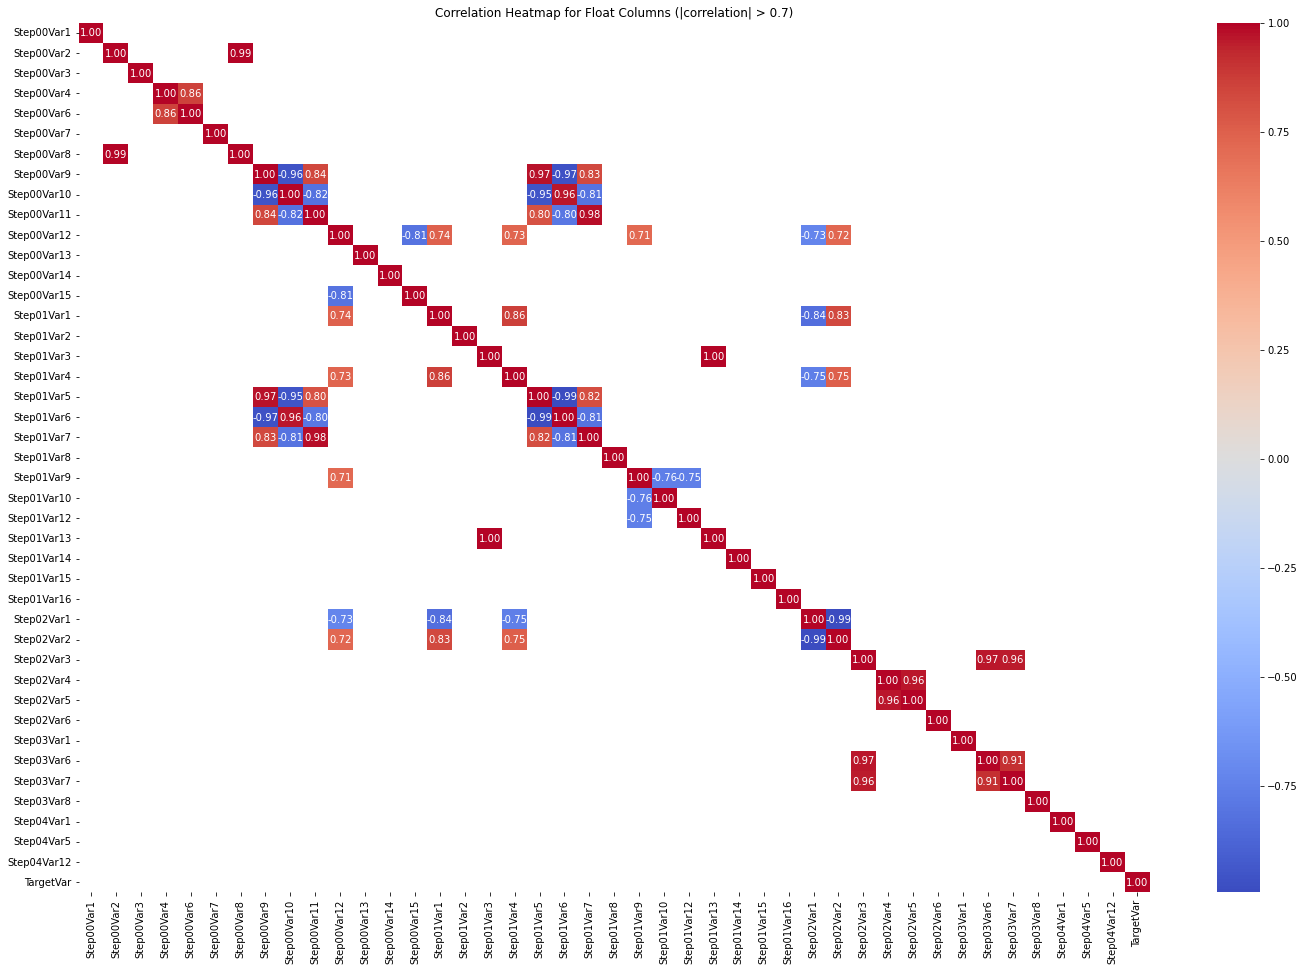

In [6]:
# Select only floating-point columns
float_cols = df.select_dtypes(include=[np.float64]).columns

# Compute the correlation matrix for floating-point columns
correlation_matrix_floats = df[float_cols].corr()

# Filter the correlation matrix to show only correlations above a certain threshold
threshold = 0.7
correlation_matrix_filtered_floats = correlation_matrix_floats.copy()
correlation_matrix_filtered_floats[(correlation_matrix_floats.abs() < threshold)] = np.nan

# Plot the heatmap with the filtered correlation matrix for float columns
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix_filtered_floats, annot=True, fmt=".2f", cmap="coolwarm", mask=correlation_matrix_filtered_floats.isnull())
plt.title(f"Correlation Heatmap for Float Columns (|correlation| > {threshold})")
plt.show()

In [7]:
# Extract pairs of highly correlated variables
high_corr_pairs = correlation_matrix_floats.unstack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Filter out self-correlations and correlations below the threshold
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Variable1'] != high_corr_pairs['Variable2']) & 
                                  (abs(high_corr_pairs['Correlation']) > 0.90)]

# Sort by absolute correlation value
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

high_corr_pairs

,Variable1,Variable2,Correlation
1091,Step01Var13,Step01Var3,0.999506
713,Step01Var3,Step01Var13,0.999506
49,Step00Var2,Step00Var8,0.994503
259,Step00Var8,Step00Var2,0.994503
869,Step01Var7,Step00Var11,0.978939
407,Step00Var11,Step01Var7,0.978939
781,Step01Var5,Step00Var9,0.969308
319,Step00Var9,Step01Var5,0.969308
1579,Step03Var6,Step02Var3,0.968673
1369,Step02Var3,Step03Var6,0.968673


In [8]:
# Create a consistent representation of variable pairs
high_corr_pairs['Pair'] = high_corr_pairs.apply(
    lambda row: tuple(sorted([row['Variable1'], row['Variable2']])), axis=1
)

# Drop duplicate pairs
high_corr_pairs = high_corr_pairs.drop_duplicates(subset='Pair')

# Remove the auxiliary 'Pair' column
high_corr_pairs = high_corr_pairs.drop(columns='Pair')

# Reset index for a clean DataFrame
high_corr_pairs = high_corr_pairs.reset_index(drop=True)

# Display the cleaned DataFrame
high_corr_pairs

,Variable1,Variable2,Correlation
0,Step01Var13,Step01Var3,0.999506
1,Step00Var2,Step00Var8,0.994503
2,Step01Var7,Step00Var11,0.978939
3,Step01Var5,Step00Var9,0.969308
4,Step03Var6,Step02Var3,0.968673
5,Step01Var6,Step00Var10,0.964592
6,Step02Var5,Step02Var4,0.961764
7,Step02Var3,Step03Var7,0.956603
8,Step03Var7,Step03Var6,0.910594
9,Step01Var5,Step00Var10,-0.954927


In [9]:
# Set to keep track of already seen variables
seen_variables = set()

# Set to store variables to drop
variables_to_drop = set()

# Iterate through the cleaned high correlation pairs
for _, row in high_corr_pairs.iterrows():
    var1, var2 = row['Variable1'], row['Variable2']
    # If neither variable is seen, keep one and drop the other
    if var1 not in seen_variables and var2 not in seen_variables:
        seen_variables.add(var1)
        variables_to_drop.add(var2)
    # If one variable is already retained, ensure the other is dropped
    elif var1 in seen_variables:
        variables_to_drop.add(var2)
    elif var2 in seen_variables:
        variables_to_drop.add(var1)

# Drop redundant variables from the DataFrame
df_reduced = df.drop(columns=list(variables_to_drop), errors='ignore')

# Display the reduced DataFrame columns
df_reduced_columns = df_reduced.columns

df_reduced.shape

(4529, 69)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Drop non-numeric columns
X = df_reduced.drop(columns=['TargetVar', 'MaskID', 'TypeID', 'Date', 'Year', 'Month', 'Day', 'Weekday'], errors='ignore')
y = df_reduced['TargetVar']

# Identify numeric columns
numeric_features = X.select_dtypes(include=['number']).columns

# Standardize numeric features
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

# Train Lasso Regression
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

# Compile performance results
performance_results = pd.DataFrame({
    "Model": ["Ridge Regression", "Lasso Regression"],
    "MSE": [ridge_mse, lasso_mse],
    "R-Squared": [ridge_r2, lasso_r2]
})

# Extract feature coefficients for both models
ridge_coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": ridge_model.coef_
}).sort_values(by="Coefficient", ascending=False)

lasso_coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_model.coef_
}).sort_values(by="Coefficient", ascending=False)

# Display the performance results
print("\nModel Performance Results:")
print(performance_results)

# Display Ridge regression coefficients
print("\nRidge Coefficients:")
print(ridge_coefficients)

# Display Lasso regression coefficients
print("\nLasso Coefficients:")
print(lasso_coefficients)



Model Performance Results:
              Model       MSE  R-Squared
0  Ridge Regression  0.000488   0.530481
1  Lasso Regression  0.000746   0.282680

Ridge Coefficients:
                           Feature  Coefficient
13                      Step01Var5     0.014530
49     Step04Var4_Less than a Dime     0.007676
52                   Step04Var7_4+     0.005333
31                     Step04Var12     0.005307
3                       Step00Var4     0.004857
11                      Step01Var2     0.003611
43     Step03Var4_Less than a Dime     0.003277
47                   Step04Var3_4+     0.002822
16                      Step01Var9     0.002554
5                       Step00Var7     0.002232
57          Step04Var9_Some Effect     0.002123
41                   Step03Var3_4+     0.001776
6                      Step00Var12     0.001731
22                     Step01Var16     0.001334
40                  Step03Var3_2-3     0.001312
1                       Step00Var2     0.001275
2           

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import pandas as pd

# Drop non-numeric columns
X = df_reduced.drop(columns=['TargetVar', 'MaskID', 'TypeID', 'Date', 'Year', 'Month', 'Day', 'Weekday'], errors='ignore')
y = df_reduced['TargetVar']

# Identify numeric columns
numeric_features = X.select_dtypes(include=['number']).columns

# Standardize numeric features
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Make predictions
lgb_pred = lgb_model.predict(X_test)

# Evaluate the model
lgb_mse = mean_squared_error(y_test, lgb_pred)
lgb_r2 = r2_score(y_test, lgb_pred)

# Display results
print("LightGBM Model Performance:")
print(f"Mean Squared Error: {lgb_mse}")
print(f"R-Squared: {lgb_r2}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3911
[LightGBM] [Info] Number of data points in the train set: 3623, number of used features: 55
[LightGBM] [Info] Start training from score 0.100096
LightGBM Model Performance:
Mean Squared Error: 0.0004709566213773003
R-Squared: 0.5471586212674615


Epoch 1/100
199/199 [==============================] - 1s 3ms/step - loss: 0.2004 - mae: 0.1374 - val_loss: 0.1464 - val_mae: 0.0480 - lr: 0.0010
Epoch 2/100
199/199 [==============================] - 0s 2ms/step - loss: 0.1391 - mae: 0.0613 - val_loss: 0.1215 - val_mae: 0.0310 - lr: 0.0010
Epoch 3/100
199/199 [==============================] - 0s 2ms/step - loss: 0.1123 - mae: 0.0421 - val_loss: 0.0988 - val_mae: 0.0269 - lr: 0.0010
Epoch 4/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.0338 - val_loss: 0.0782 - val_mae: 0.0235 - lr: 0.0010
Epoch 5/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0706 - mae: 0.0295 - val_loss: 0.0607 - val_mae: 0.0219 - lr: 0.0010
Epoch 6/100
199/199 [==============================] - 1s 2ms/step - loss: 0.0538 - mae: 0.0244 - val_loss: 0.0460 - val_mae: 0.0201 - lr: 0.0010
Epoch 7/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0404 - mae: 0.0222 - val_loss: 0.0343 - val_mae

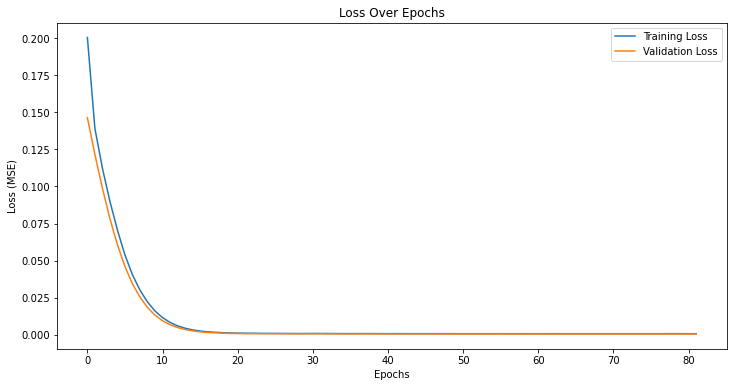

In [ ]:
# Step 1: Preprocessing
# Drop non-numeric columns
X = df_reduced.drop(columns=['TargetVar', 'MaskID', 'TypeID', 'Date', 'Year', 'Month', 'Day', 'Weekday'], errors='ignore')
y = df_reduced['TargetVar']

# Identify numeric columns
numeric_features = X.select_dtypes(include=['number']).columns

# Standardize numeric features
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 2: Define the Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 3: Callbacks for Fine-Tuning
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Step 4: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Increase epochs for more learning
    batch_size=16,  # Experiment with different batch sizes
    callbacks=callbacks,
    verbose=1
)

# Step 5: Evaluate the Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Fine-Tuned Neural Network Model Performance:")
print(f"Mean Squared Error: {mse}")
print(f"R-Squared: {r2}")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()